# NH 주식보유기간 예측

<img src='./logo.png'>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'

#-------------------- 주피터 셀 넓이 조절 ---------------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', None)
sns.set()

In [2]:
item_info_df = pd.read_csv("./open/iem_info_20210902.csv")
train_df     = pd.read_csv("./open/stk_hld_train.csv", dtype={'act_id':np.str,'iem_cd':np.str, 'byn_dt':np.str, 'hold_d':np.int64})     #np.datetime64
test_df      = pd.read_csv("./open/stk_hld_test.csv" , dtype={'act_id':np.str,'iem_cd':np.str, 'byn_dt':np.str, 'hist_d':np.int64, 'submit_id':np.str, 'hold_d':np.int64})    
hist_df      = pd.read_csv("./open/stk_bnc_hist.csv" , dtype={'act_id':np.str,'iem_cd':np.str, 'bse_dt':np.str, 'bnc_qty':np.int64, 'tot_aet_amt':np.int64, 'stk_par_pr':np.int64})   

In [3]:
# ID의 첫 글자 떼어내기
item_info_df['iem_cd'] = item_info_df['iem_cd'].str[1:]
train_df['iem_cd']     = train_df['iem_cd'].str[1:]
test_df['iem_cd']      = test_df['iem_cd'].str[1:]
hist_df['iem_cd']      = hist_df['iem_cd'].str[1:]
hist_df['ing'] = 0

In [4]:
# hist를 계좌ID, 종목코드, 기준일 순으로 sorting 후 자료의 30%만 보기
hist_df = hist_df.sort_values(['act_id','iem_cd','bse_dt'])
slen = int(len(hist_df) *0.3)
hist_df = hist_df[:slen].copy()
hist_df.head()

,act_id,bse_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr,ing
1951306,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c5467ece45d5b35e99912a,20190321,002270,1,667000,5000,0
1951307,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c5467ece45d5b35e99912a,20190328,002270,2,1270000,5000,0
1951308,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c5467ece45d5b35e99912a,20190507,002270,3,1815000,5000,0
1951309,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c5467ece45d5b35e99912a,20190716,002270,4,2104000,5000,0
1951310,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c5467ece45d5b35e99912a,20200129,002270,8,2964000,5000,0


In [5]:
# train과 hist를 merge : train 기준으로 계좌ID, 종목코드, 매수일 (--- 기준일)
# hsit의 기준일(거래일들)은 최초 매수일만 남는다... (?)
train = pd.merge(train_df, hist_df, how='left', left_on=['act_id','iem_cd','byn_dt'], right_on=['act_id','iem_cd','bse_dt'])
test  = pd.merge(test_df,  hist_df, how='left', left_on=['act_id','iem_cd','byn_dt'], right_on=['act_id','iem_cd','bse_dt'])

In [6]:
train.head()

,act_id,iem_cd,byn_dt,hold_d,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,ing
0,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,006360,20180726,11,20180726,274.0,11782000.0,5000.0,0.0
1,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,005930,20180131,80,20180131,2.0,4990000.0,5000.0,0.0
2,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,005070,20180517,5,20180517,786.0,14619600.0,1000.0,0.0
3,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,003520,20201112,22,20201112,60.0,462000.0,500.0,0.0
4,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,002310,20180905,324,20180905,183.0,8125200.0,5000.0,0.0


In [7]:
test.head()

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,ing
0,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,032640,20200522,153,IDX00001,0,20200522,300.0,3945000.0,5000.0,0.0
1,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,160600,20190823,335,IDX00002,0,20190823,198.0,2524500.0,500.0,0.0
2,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,234340,20200611,139,IDX00003,0,20200611,138.0,4291800.0,500.0,0.0
3,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,131760,20200120,236,IDX00004,0,20200120,2972.0,6716720.0,500.0,0.0
4,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,293490,20201217,9,IDX00005,0,20201217,10.0,464500.0,100.0,0.0


# 1. 매트릭스 계산

In [8]:
## 월별 수익

train['byn_dt'] = pd.to_datetime(train['byn_dt'])                                # train의 매수일을 날짜로 변환 
train['yymm'] = train['byn_dt'].map(lambda date: 100*date.year + date.month)     # train의 매수일을 연, 월로 추출 
train['return_val'] = train['bnc_qty'] * train['tot_aet_amt']                    # 잔고수량 * 잔고금액
revenue = train.groupby(['yymm'])['return_val'].sum().reset_index()              # 연월별 수익 데이터프레임 생성
revenue.head()

,yymm,return_val
0,201601,6.993321e+12
1,201602,5.539925e+11
2,201603,6.818345e+11
3,201604,4.091605e+12
4,201605,3.566704e+12


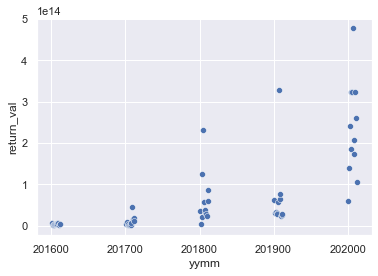

In [9]:
# 연월별 수익 분포(산점도) :2020년, 즉 최근 구매 분산 高, 수익률 高 -> 가중치 줄 필요 有
sns.scatterplot(data=revenue, x="yymm", y="return_val")
plt.show()

Text(0, 0.5, 'return_val')

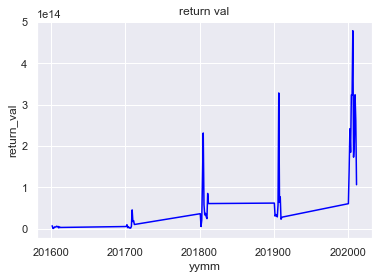

In [10]:
# 연월별 수익 분포(plot차트) :2020년, 즉 최근 구매 분산 高, 수익률 高 -> 가중치 줄 필요 有
plt.plot(revenue['yymm'], revenue['return_val'], color = 'blue')
plt.title("return val")
plt.xlabel("yymm")
plt.ylabel("return_val")

In [11]:
# 전날 종가로부터의 수익률 계산
revenue['return_rate'] = revenue['return_val'].pct_change()
revenue.head()

,yymm,return_val,return_rate
0,201601,6.993321e+12,NaN
1,201602,5.539925e+11,-0.920783
2,201603,6.818345e+11,0.230765
3,201604,4.091605e+12,5.000877
4,201605,3.566704e+12,-0.128287


Text(0, 0.5, 'return_val')

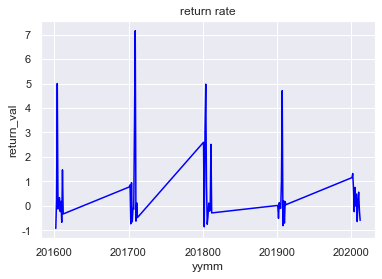

In [12]:
# 2020년 누적수익률은 오히려 Down
# (2020년 체결량(거래량) 증가했음에도..)
plt.plot(revenue['yymm'], revenue['return_rate'], color = 'blue')
plt.title("return rate")
plt.xlabel("yymm")
plt.ylabel("return_val")

# 월별 고객 추이

In [13]:
# 연월별 계좌ID (고객) 수
monthly_user = train.groupby('yymm')['act_id'].nunique().reset_index()
monthly_user.head()

,yymm,act_id
0,201601,71
1,201602,47
2,201603,43
3,201604,43
4,201605,49


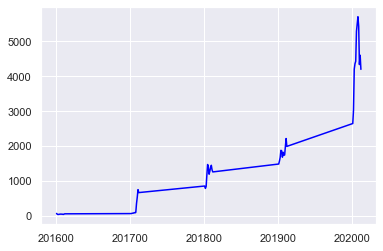

In [14]:
plt.plot(monthly_user['yymm'], monthly_user['act_id'], color = 'blue')
plt.show()

# 월간 주문 수

In [15]:
monthly_sales = train.groupby('yymm')['bnc_qty'].sum().reset_index()
monthly_sales.head()

,yymm,bnc_qty
0,201601,288865.0
1,201602,73361.0
2,201603,76218.0
3,201604,172824.0
4,201605,224895.0


In [16]:
monthly_order_avg = train.groupby('yymm')['bnc_qty'].sum().reset_index()
monthly_order_avg.head()

,yymm,bnc_qty
0,201601,288865.0
1,201602,73361.0
2,201603,76218.0
3,201604,172824.0
4,201605,224895.0


# 주문 당 평균 수익

In [17]:
monthly_order_avg = train.groupby('yymm')['return_val'].mean().reset_index()
monthly_order_avg.head()

,yymm,return_val
0,201601,2.775127e+10
1,201602,5.378568e+09
2,201603,5.454676e+09
3,201604,4.011377e+10
4,201605,2.565974e+10


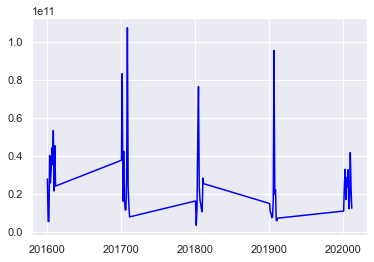

In [18]:
plt.plot(monthly_order_avg['yymm'], monthly_order_avg['return_val'], \
         color = 'blue')
plt.show()

## 매월 각 유저의 수익 내역

In [19]:
min_purchase = train.groupby('act_id')['byn_dt'].min().reset_index()
min_purchase.columns = ['act_id','min_pur_date']
min_purchase['min_pur_date'] = pd.to_datetime(min_purchase['min_pur_date'])
min_purchase['min_pur_yymm'] = min_purchase['min_pur_date'].map(lambda date: 100*date.year + date.month)
train = pd.merge(train, min_purchase, on='act_id')
train.head()

,act_id,iem_cd,byn_dt,hold_d,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,ing,yymm,return_val,min_pur_date,min_pur_yymm
0,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,006360,2018-07-26,11,20180726,274.0,11782000.0,5000.0,0.0,201807,3.228268e+09,2016-01-04,201601
1,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,005930,2018-01-31,80,20180131,2.0,4990000.0,5000.0,0.0,201801,9.980000e+06,2016-01-04,201601
2,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,005070,2018-05-17,5,20180517,786.0,14619600.0,1000.0,0.0,201805,1.149101e+10,2016-01-04,201601
3,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,003520,2020-11-12,22,20201112,60.0,462000.0,500.0,0.0,202011,2.772000e+07,2016-01-04,201601
4,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,002310,2018-09-05,324,20180905,183.0,8125200.0,5000.0,0.0,201809,1.486912e+09,2016-01-04,201601


In [20]:
train['user_type'] = 'new'
train.loc[train['yymm']>train['min_pur_yymm'],'user_type'] = 'old'
user_return_val = train.groupby(['yymm','act_id'])['return_val'].sum().reset_index()
user_return_val.head()

,yymm,act_id,return_val
0,201601,05f0ec33d1973df79487e884a4e099ce0a67f2f58647ddeddb8ff952732fa08d,2.338882e+10
1,201601,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,4.613335e+10
2,201601,10b0ce16d9099893611dda555bd60ff0eeb3010f092a6199b951935b6625c6c7,2.529004e+11
3,201601,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c226bfff4211d8a7bde6,1.008517e+09
4,201601,127188207e133cd6361a6966376eea6183b31077a82bd3d26ad5afb54c5dc341,9.927254e+09


## 신규/기존 고객의 수익률

In [21]:
train.query("user_type == 'old'")['return_val'].T

0         3.228268e+09
1         9.980000e+06
2         1.149101e+10
3         2.772000e+07
4         1.486912e+09
              ...     
681467    7.029178e+08
681468    1.120468e+10
681469    2.034228e+10
681470    7.756988e+08
681471    1.249300e+09
Name: return_val, Length: 641165, dtype: float64

In [22]:
train.query("user_type == 'new'")['return_val'].T

22        2.406400e+05
36        5.451100e+08
58        4.338000e+10
81        2.208000e+09
97                 NaN
              ...     
681304             NaN
681312             NaN
681320    1.542900e+10
681358    4.520246e+10
681438    1.618910e+11
Name: return_val, Length: 40307, dtype: float64

In [23]:
#create a dataframe that shows new user ratio - we also need to drop NA values (first month new user ratio is 0)
tx_user_ratio = train.query("user_type == 'new'").groupby(['yymm'])['act_id'].nunique()/train.query("user_type == 'old'").groupby(['yymm'])['act_id'].nunique() 
tx_user_ratio = tx_user_ratio.reset_index()
tx_user_ratio = tx_user_ratio.dropna()
tx_user_ratio.head()

,yymm,act_id
1,201602,0.044444
3,201604,0.023810
4,201605,0.065217
5,201606,0.061224
6,201607,0.020000


# ____________________________________________

In [24]:
# ! pip install plotly

## 최근 거래일 계산

In [25]:
from datetime import datetime, timedelta

In [26]:
item_info_df = pd.read_csv("./open/iem_info_20210902.csv")
train_df     = pd.read_csv("./open/stk_hld_train.csv", dtype={'act_id':np.str,'iem_cd':np.str, 'byn_dt':np.str, 'hold_d':np.int64})     #np.datetime64
test_df      = pd.read_csv("./open/stk_hld_test.csv" , dtype={'act_id':np.str,'iem_cd':np.str, 'byn_dt':np.str, 'hist_d':np.int64, 'submit_id':np.str, 'hold_d':np.int64})    
hist_df      = pd.read_csv("./open/stk_bnc_hist.csv" , dtype={'act_id':np.str,'iem_cd':np.str, 'bse_dt':np.str, 'bnc_qty':np.int64, 'tot_aet_amt':np.int64, 'stk_par_pr':np.int64})   

In [27]:
item_info_df['iem_cd'] = item_info_df['iem_cd'].str[1:]
train_df['iem_cd']     = train_df['iem_cd'].str[1:]
test_df['iem_cd']      = test_df['iem_cd'].str[1:]
hist_df['iem_cd']      = hist_df['iem_cd'].str[1:]
hist_df['ing'] = 0

In [28]:
hist_df = hist_df.sort_values(['act_id','iem_cd','bse_dt'])
slen = int(len(hist_df) *0.3)
hist_df = hist_df[:slen].copy()
hist_df.head()

,act_id,bse_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr,ing
1951306,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c5467ece45d5b35e99912a,20190321,002270,1,667000,5000,0
1951307,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c5467ece45d5b35e99912a,20190328,002270,2,1270000,5000,0
1951308,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c5467ece45d5b35e99912a,20190507,002270,3,1815000,5000,0
1951309,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c5467ece45d5b35e99912a,20190716,002270,4,2104000,5000,0
1951310,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c5467ece45d5b35e99912a,20200129,002270,8,2964000,5000,0


In [29]:
tx_data = pd.merge(train_df, hist_df, how='left', left_on=['act_id','iem_cd','byn_dt'], right_on=['act_id','iem_cd','bse_dt'])
test  = pd.merge(test_df,  hist_df, how='left', left_on=['act_id','iem_cd','byn_dt'], right_on=['act_id','iem_cd','bse_dt'])


#convert the string date field to datetime
tx_data['byn_dt'] = pd.to_datetime(tx_data['byn_dt'])

In [30]:
tx_user = pd.DataFrame(tx_data['act_id'].unique())
tx_user.columns = ['act_id']

max_byn_dt = tx_data.groupby('act_id')['byn_dt'].max().reset_index()
max_byn_dt.columns = ['act_id','max_byn_dt']
max_byn_dt['recent'] = (max_byn_dt['max_byn_dt'].max() - max_byn_dt['max_byn_dt']).dt.days

tx_user = pd.merge(tx_user, max_byn_dt[['act_id','recent']], on='act_id')

tx_user.head()

,act_id,recent
0,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,47
1,b6623032ed365b6c9a71c0344ebb8ca191f1ebc592777125215a8e7e85cf3395,36
2,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae64d50bc776adedf3e1,173
3,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097067e5b41a971afa1da,1821
4,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f804d2aae1393f76fa2,14


In [31]:
tx_user.describe()

,recent
count,9337.000000
mean,111.590768
std,192.902850
min,0.000000
25%,12.000000
50%,36.000000
75%,125.000000
max,1821.000000


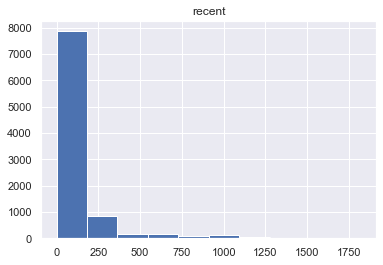

In [32]:
tx_user.hist()
plt.show()

# K-평균 클러스터링

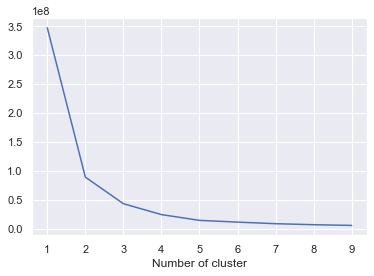

In [33]:
from sklearn.cluster import KMeans

sse={}
tx_recency = tx_user[['recent']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

# 다분류 특성 살리기위해 3 or 4 선택

In [34]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['recent']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['recent']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_user = order_cluster('RecencyCluster', 'recent',tx_user,False)
tx_user.head()

,act_id,recent,RecencyCluster
0,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,47,3
1,b6623032ed365b6c9a71c0344ebb8ca191f1ebc592777125215a8e7e85cf3395,36,3
2,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f804d2aae1393f76fa2,14,3
3,481e3dc582538315b57089931b4f9e4bf84c2b163abc091db44e8789b0b3c0aa,1,3
4,50aae09f842e3aeb50dcdbdb2c3e7db3a5a8f567acb919f7faa259342bdfdf4f,34,3


In [35]:
# 최근 방문 고객 별 군집
tx_user.groupby('RecencyCluster')['recent'].describe()  

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,275.0,971.647273,139.452328,756.0,882.0,956.0,1047.0,1821.0
1,358.0,536.913408,112.957521,355.0,426.5,540.0,623.5,753.0
2,2368.0,174.613598,64.711630,102.0,123.0,153.0,214.0,354.0
3,6336.0,26.676136,26.177861,0.0,7.0,18.0,40.0,99.0


# 주문빈도

In [36]:
tx_frequency = train.groupby('act_id')['byn_dt'].count().reset_index()
tx_frequency.columns = ['act_id','freq']
tx_user = pd.merge(tx_user, tx_frequency, on='act_id')
tx_user.head()

,act_id,recent,RecencyCluster,freq
0,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,47,3,94
1,b6623032ed365b6c9a71c0344ebb8ca191f1ebc592777125215a8e7e85cf3395,36,3,24
2,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f804d2aae1393f76fa2,14,3,63
3,481e3dc582538315b57089931b4f9e4bf84c2b163abc091db44e8789b0b3c0aa,1,3,129
4,50aae09f842e3aeb50dcdbdb2c3e7db3a5a8f567acb919f7faa259342bdfdf4f,34,3,117


<AxesSubplot:>

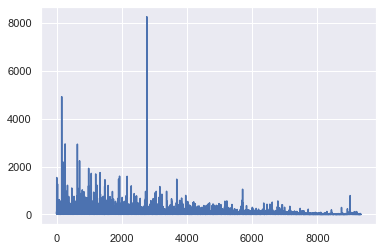

In [37]:
tx_user['freq'].plot()

<AxesSubplot:>

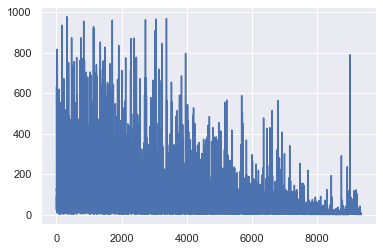

In [38]:
tx_user.query('freq < 1000')['freq'].plot()

# K-means cluster + 주문빈도

In [39]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['freq']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['freq']])

tx_user = order_cluster('FrequencyCluster', 'freq', tx_user,True)

# 주문 빈도 별 군집
tx_user.groupby('FrequencyCluster')['freq'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,8446.0,38.964835,41.653635,1.0,8.00,23.0,56.00,182.0
1,837.0,325.389486,139.041365,183.0,222.00,273.0,385.00,796.0
2,52.0,1285.250000,498.239720,816.0,950.00,1100.5,1493.25,2948.0
3,2.0,6595.500000,2362.443756,4925.0,5760.25,6595.5,7430.75,8266.0


# 투자비용 별 클러스터링

In [40]:
tx_revenue = train.groupby('act_id')['tot_aet_amt'].sum().reset_index()
tx_user = pd.merge(tx_user, tx_revenue, on='act_id')
tx_user.head()

,act_id,recent,RecencyCluster,freq,FrequencyCluster,tot_aet_amt
0,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,47,3,94,0,3.830028e+08
1,b6623032ed365b6c9a71c0344ebb8ca191f1ebc592777125215a8e7e85cf3395,36,3,24,0,0.000000e+00
2,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f804d2aae1393f76fa2,14,3,63,0,0.000000e+00
3,481e3dc582538315b57089931b4f9e4bf84c2b163abc091db44e8789b0b3c0aa,1,3,129,0,1.161312e+09
4,50aae09f842e3aeb50dcdbdb2c3e7db3a5a8f567acb919f7faa259342bdfdf4f,34,3,117,0,0.000000e+00


<AxesSubplot:>

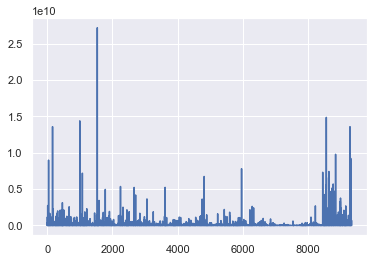

In [41]:
tx_user['tot_aet_amt'].plot()

In [42]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['tot_aet_amt']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['tot_aet_amt']])

tx_user = order_cluster('RevenueCluster', 'tot_aet_amt',tx_user,True)

# 투자비용 별 클러스터링
tx_user.groupby('RevenueCluster')['tot_aet_amt'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,9085.0,2.444154e+07,8.238087e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.706500e+05,6.773220e+08
1,220.0,1.335609e+09,6.283340e+08,6.809119e+08,8.546104e+08,1.125386e+09,1.617393e+09,3.645807e+09
2,27.0,6.084765e+09,1.659555e+09,3.764467e+09,4.842426e+09,5.704085e+09,7.254834e+09,9.791030e+09
3,5.0,1.673380e+10,5.884106e+09,1.359097e+10,1.359582e+10,1.439324e+10,1.487503e+10,2.721394e+10


In [43]:
# 전체 점수

In [44]:
tx_user['tot_score'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user.groupby('tot_score')['recent','freq','tot_aet_amt'].mean()

,recent,freq,tot_aet_amt
tot_score,,,
0,972.622711,6.183150,9.488383e+06
1,539.296919,17.316527,1.008331e+07
2,175.003429,19.109730,1.464825e+07
3,30.487013,50.628015,2.931892e+07
4,12.000000,290.786503,2.379195e+08
5,7.852941,600.808824,1.227463e+09
6,13.814815,1097.814815,5.483938e+09
7,7.800000,1344.200000,8.590581e+09
8,0.000000,1071.000000,1.359097e+10


In [45]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['tot_score']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['tot_score']>4,'Segment'] = 'High-Value'

# 구매일 예측

In [46]:
train.head()

,act_id,iem_cd,byn_dt,hold_d,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,ing,yymm,return_val,min_pur_date,min_pur_yymm,user_type
0,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,006360,2018-07-26,11,20180726,274.0,11782000.0,5000.0,0.0,201807,3.228268e+09,2016-01-04,201601,old
1,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,005930,2018-01-31,80,20180131,2.0,4990000.0,5000.0,0.0,201801,9.980000e+06,2016-01-04,201601,old
2,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,005070,2018-05-17,5,20180517,786.0,14619600.0,1000.0,0.0,201805,1.149101e+10,2016-01-04,201601,old
3,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,003520,2020-11-12,22,20201112,60.0,462000.0,500.0,0.0,202011,2.772000e+07,2016-01-04,201601,old
4,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,002310,2018-09-05,324,20180905,183.0,8125200.0,5000.0,0.0,201809,1.486912e+09,2016-01-04,201601,old


In [47]:
test.head()

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,ing
0,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,032640,20200522,153,IDX00001,0,20200522,300.0,3945000.0,5000.0,0.0
1,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,160600,20190823,335,IDX00002,0,20190823,198.0,2524500.0,500.0,0.0
2,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,234340,20200611,139,IDX00003,0,20200611,138.0,4291800.0,500.0,0.0
3,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,131760,20200120,236,IDX00004,0,20200120,2972.0,6716720.0,500.0,0.0
4,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,293490,20201217,9,IDX00005,0,20201217,10.0,464500.0,100.0,0.0


In [48]:
train_now = train[(train['byn_dt'] >=  pd.to_datetime('2016-01-01')) & (train['byn_dt'] <=  pd.to_datetime('2019-12-31'))].reset_index(drop=True)
train_next = train[(train['byn_dt'] >=  pd.to_datetime('2020-01-01')) & (train['byn_dt'] <=  pd.to_datetime('2020-12-31'))].reset_index(drop=True)

In [49]:
train_now.head()

,act_id,iem_cd,byn_dt,hold_d,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,ing,yymm,return_val,min_pur_date,min_pur_yymm,user_type
0,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,006360,2018-07-26,11,20180726,274.0,11782000.0,5000.0,0.0,201807,3.228268e+09,2016-01-04,201601,old
1,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,005930,2018-01-31,80,20180131,2.0,4990000.0,5000.0,0.0,201801,9.980000e+06,2016-01-04,201601,old
2,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,005070,2018-05-17,5,20180517,786.0,14619600.0,1000.0,0.0,201805,1.149101e+10,2016-01-04,201601,old
3,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,002310,2018-09-05,324,20180905,183.0,8125200.0,5000.0,0.0,201809,1.486912e+09,2016-01-04,201601,old
4,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,002230,2018-08-06,98,20180806,700.0,4039000.0,500.0,0.0,201808,2.827300e+09,2016-01-04,201601,old


In [50]:
train_next.head()

,act_id,iem_cd,byn_dt,hold_d,bse_dt,bnc_qty,tot_aet_amt,stk_par_pr,ing,yymm,return_val,min_pur_date,min_pur_yymm,user_type
0,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,003520,2020-11-12,22,20201112,60.0,462000.0,500.0,0.0,202011,2.772000e+07,2016-01-04,201601,old
1,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,000400,2020-05-12,22,20200512,500.0,945000.0,1000.0,0.0,202005,4.725000e+08,2016-01-04,201601,old
2,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,000100,2020-04-08,1,20200408,152.0,7075600.0,1000.0,0.0,202004,1.075491e+09,2016-01-04,201601,old
3,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,032500,2020-01-29,50,20200129,100.0,5560000.0,500.0,0.0,202001,5.560000e+08,2016-01-04,201601,old
4,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534,042000,2020-05-13,6,20200513,68.0,3032800.0,500.0,0.0,202005,2.062304e+08,2016-01-04,201601,old


In [51]:
user_df = pd.DataFrame(train_now['act_id'].unique())
user_df.columns = ['act_id']
user_df.head()

,act_id
0,0ad104dbed99be0cd858aa772765ddedade554601a981bec9b177d8416085534
1,b6623032ed365b6c9a71c0344ebb8ca191f1ebc592777125215a8e7e85cf3395
2,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae64d50bc776adedf3e1
3,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097067e5b41a971afa1da
4,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f804d2aae1393f76fa2


In [52]:
train_next_first_byndt = train_next.groupby('act_id')['byn_dt'].min().reset_index()
train_next_first_byndt.columns = ['act_id','min_byndt_date']
train_next_first_byndt.head()


# max byn_dt 기준 최대 구매일 
tx_last_byndt = train_now.groupby('act_id')['byn_dt'].max().reset_index()
tx_last_byndt.columns = ['act_id','max_byndt_date']


tx_byndt_dates = pd.merge(tx_last_byndt,train_next_first_byndt,on='act_id',how='left')

tx_byndt_dates['min_byndt_date'] = pd.to_datetime(tx_byndt_dates['min_byndt_date'])
tx_byndt_dates['max_byndt_date'] = pd.to_datetime(tx_byndt_dates['max_byndt_date'])
tx_byndt_dates['next_byndt_date'] = (tx_byndt_dates['min_byndt_date'] - tx_byndt_dates['max_byndt_date']).dt.days


user_df = pd.merge(user_df, tx_byndt_dates[['act_id','next_byndt_date']],on='act_id',how='left')
user_df.head()

user_df['next_byndt_date'].unique()

array([ 342.,  587.,  120.,   nan,   77., 1029.,  298.,    4.,  736.,
          3.,   18.,    6.,  905.,   16.,  279.,  161.,  191.,   15.,
       1252.,   22.,   40.,   37.,  719.,   35.,  110.,   21.,  109.,
        136.,  267.,   19.,    9.,  516.,  323.,  192.,  103.,   99.,
         53.,  352.,   12., 1098.,  304.,   43.,   30.,  107.,  219.,
        259., 1232.,  322.,  225.,   45.,   56.,  454.,   32.,  274.,
        168.,  859.,  203.,  195.,  849.,   48.,  314.,   95.,   14.,
       1198.,  391.,  158.,  393.,   25.,   84.,   20.,  379., 1142.,
        101.,  143.,  590.,  111.,  386.,   13.,  283.,   85.,  144.,
        456.,   10.,  696., 1139.,  261.,   34.,  738.,  855.,  150.,
         75.,   23.,  287.,   47.,  532.,  348., 1336.,  424., 1127.,
        213.,   55.,  602.,    7.,  729.,  369.,   65.,   68.,  511.,
        288.,  433.,  885.,   33.,  493.,  300.,  636.,  825.,  828.,
        407.,   17.,  113.,   78.,  299.,  476.,  892.,  930.,   46.,
        485.,   50.,